<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/TRANSFORMER_ufficiale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Upload cleaned dataset

In this section, we begin by preparing the dataset for processing and modeling. The raw data consists of annotated text where each token is associated with a specific label. We perform some basic preprocessing steps, such as calculating the sequence length, which is defined as the difference between the "Start" and "End" positions for each token in the text.

We then inspect the sequence length distribution using the df['sequence_length'].describe() function. The resulting statistics show that **the average sequence length is approximately 6.59 tokens, with the majority of sequences ranging from 4 to 9 tokens in length. The longest sequences have a length of 32 tokens**. This distribution helps us understand the typical size of the text sequences in our dataset, ensuring that the tokenizer and model configurations are optimized for handling these sequences during training.

Such analysis is crucial for tasks like padding and truncation, allowing us to set appropriate maximum sequence lengths for our model, thus ensuring efficient training and evaluation processes.

In [1]:
import pandas as pd
from google.colab import files

# Carica il file CSV
uploaded = files.upload()

Saving cleaned_dataset_NN.csv to cleaned_dataset_NN (5).csv


In [2]:
# Leggi il file CSV con Pandas
for filename in uploaded.keys():
    df = pd.read_csv(filename)

df.head()

,id,Start,End,Label
0,Ventricular,0,11,B-Multi-tissue_structure
1,fibrillation,12,24,O
2,long,32,36,O
3,QT,37,39,O
4,syndrome,40,48,O


In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [4]:
pip install transformers

In [5]:
!pip install datasets


In [6]:
!pip install evaluate

In [7]:
!pip install seqeval

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import AutoTokenizer
from datasets import Dataset
import os


In [9]:
df['sequence_length'] = df['End'] - df['Start']
print(df['sequence_length'].describe())


count    60979.000000
mean         6.588252
std          3.391699
min          1.000000
25%          4.000000
50%          7.000000
75%          9.000000
max         32.000000
Name: sequence_length, dtype: float64


#Splitting the dataset and rebalancing classes
In this section, we begin by exploring the unique labels present in the dataset using df['Label'].unique(). This helps us understand the variety of categories we are working with. Next, we analyze the frequency of each label using df['Label'].value_counts(), which provides us with the label distribution in the dataset.

From the output, as we already know, we can observe that the label "O" (Other) is the most frequent, followed by labels such as "B-Cell" and "B-Multi-tissue_structure." Some categories, such as "I-Developing_anatomical_structure" and "I-Immaterial_anatomical_entity," are heavily underrepresented, with very few occurrences. This indicates a significant class imbalance.

Next, **we check the number of unique labels for each ID** using df.groupby('id')['Label'].nunique(). This gives us an idea of how many different labels are associated with each ID. We observe that some IDs are associated with more than one label, which we consider in the following steps to avoid confusion in the classification task. We filter out the IDs with only one label to focus on those relevant for training.

Finally, the labels are grouped by ID using df.groupby('id')['Label'].first(), ensuring that **each ID is assigned a unique label based on its first occurrence in the dataset**. This is necessary for consistent training and helps avoid errors related to multiple labels for the same ID.

In [10]:
# Valori unici di Label
print("\nCategorie di Label:")
print(df['Label'].unique())

# Frequenza delle etichette
print("\nDistribuzione delle etichette:")
print(df['Label'].value_counts())



Categorie di Label:
['B-Multi-tissue_structure' 'O' 'B-Organism_substance'
 'B-Organism_subdivision' 'B-Organ' 'I-Multi-tissue_structure'
 'B-Cellular_component' 'I-Cellular_component' 'B-Cell' 'I-Cell'
 'B-Immaterial_anatomical_entity' 'B-Tissue' 'I-Tissue'
 'B-Pathological_formation' 'B-Anatomical_system' 'I-Organism_substance'
 'I-Anatomical_system' 'I-Pathological_formation'
 'I-Immaterial_anatomical_entity' 'I-Organ' 'I-Organism_subdivision'
 'B-Developing_anatomical_structure' 'I-Developing_anatomical_structure']

Distribuzione delle etichette:
Label
O                                    56455
B-Cell                                 775
B-Multi-tissue_structure               639
I-Cell                                 439
B-Organ                                381
B-Pathological_formation               367
I-Multi-tissue_structure               358
B-Organism_substance                   288
I-Pathological_formation               224
B-Cellular_component                   199
B-Tiss

In [14]:
from sklearn.utils import resample

# Rimuovere la classe I-Developing_anatomical_structure da tutto il dataset
df = df[df['Label'] != 'I-Developing_anatomical_structure']

# Suddivisione del dataset in train, validation e test
unique_ids = df['id'].unique()
shuffled_ids = pd.Series(unique_ids).sample(frac=1, random_state=42).values
train_ids, temp_ids = train_test_split(shuffled_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

train_df = df[df['id'].isin(train_ids)]
val_df = df[df['id'].isin(val_ids)]
test_df = df[df['id'].isin(test_ids)]

# Mostrare le dimensioni dei subset
print(f"Training set: {train_df.shape[0]} righe")
print(f"Validation set: {val_df.shape[0]} righe")
print(f"Test set: {test_df.shape[0]} righe")


Training set: 42163 righe
Validation set: 10320 righe
Test set: 8491 righe


In [15]:
print(train_df['Label'].value_counts())

Label
O                                    38911
B-Cell                                 543
B-Multi-tissue_structure               464
I-Cell                                 355
B-Organ                                286
B-Pathological_formation               256
I-Multi-tissue_structure               254
B-Organism_substance                   171
I-Pathological_formation               156
B-Cellular_component                   142
B-Organism_subdivision                 131
B-Tissue                               118
I-Tissue                                71
I-Cellular_component                    55
B-Immaterial_anatomical_entity          50
I-Organism_substance                    40
I-Organ                                 38
B-Anatomical_system                     35
B-Developing_anatomical_structure       33
I-Anatomical_system                     25
I-Immaterial_anatomical_entity          16
I-Organism_subdivision                  13
Name: count, dtype: int64


##Rebalancing Training set
In this section, the training dataset is rebalanced to address the issue of class imbalance. We use sklearn.utils' resample function to **increase the number of samples for underrepresented classes**, ensuring that every class in the training set has the same number of examples as the most frequent class. This process helps prevent the model from learning to predict only the majority classes, thereby improving its ability to recognize the rare classes.

Afterward, the **rebalanced data is shuffled** using the sample() method from pandas to ensure that the order of the examples does not affect training. Finally, we print the distribution of labels in the rebalanced training set to verify that the balancing has been correctly applied.

In [16]:
from sklearn.utils import resample

# Separare la classe maggioritaria (O) e le altre classi nel train set
majority_class = train_df[train_df['Label'] == 'O']
minority_classes = train_df[train_df['Label'] != 'O']

# Undersampling della classe O nel train set
undersampled_majority = resample(majority_class,
                                 replace=False,  # Campionamento senza sostituzione
                                 n_samples=10000,  # Numero target (esempio: 10k)
                                 random_state=42)

# Oversampling delle classi minoritarie nel train set
balanced_minority = minority_classes.groupby('Label', group_keys=False).apply(
    lambda x: resample(x,
                       replace=True,  # Campionamento con sostituzione
                       n_samples=1000,  # Numero target (esempio: 1k per classe)
                       random_state=42)
)

# Unire i dati bilanciati nel train set
balanced_train_df = pd.concat([undersampled_majority, balanced_minority])

# Mescolare i dati bilanciati
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Controllare la nuova distribuzione delle classi nel train set
print("Distribuzione delle classi nel train set bilanciato:")
print(balanced_train_df['Label'].value_counts())

# Validation e test restano invariati
print("Distribuzione delle classi nel validation set:")
print(val_df['Label'].value_counts())

print("Distribuzione delle classi nel test set:")
print(test_df['Label'].value_counts())


Distribuzione delle classi nel train set bilanciato:
Label
O                                    10000
I-Multi-tissue_structure              1000
B-Cellular_component                  1000
I-Immaterial_anatomical_entity        1000
I-Cell                                1000
B-Cell                                1000
B-Multi-tissue_structure              1000
I-Anatomical_system                   1000
I-Organism_substance                  1000
B-Tissue                              1000
B-Organism_substance                  1000
B-Organ                               1000
I-Cellular_component                  1000
I-Organ                               1000
I-Tissue                              1000
B-Developing_anatomical_structure     1000
I-Pathological_formation              1000
I-Organism_subdivision                1000
B-Pathological_formation              1000
B-Anatomical_system                   1000
B-Organism_subdivision                1000
B-Immaterial_anatomical_entity        

<ipython-input-16-dcf310e8b152>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_minority = minority_classes.groupby('Label', group_keys=False).apply(


#Mapping NER tags
After identifying all unique NER labels in the balanced training set, we created two mapping dictionaries:

* **tag2id**: This dictionary associates each unique NER label with a unique numeric ID. This is essential for converting the categorical labels into a format suitable for deep learning models.

* **id2tag**: This dictionary performs the reverse mapping, converting numeric IDs back into the corresponding NER labels, which helps in interpreting model predictions during evaluation.

We then apply the tag2id mapping to the training, validation, and test datasets. This replaces the original NER labels with their respective numeric IDs, making the data compatible with the Hugging Face model and enabling the model to work with these numeric representations during training and evaluation.

Finally, we printed the tag2id mapping to verify that each label has been correctly mapped to its corresponding ID.

In [20]:
# Creiamo una lista di tutte le etichette presenti nel training set bilanciato
all_labels = balanced_train_df['Label'].unique()

# Creiamo il mapping delle etichette
tag2id = {tag: idx for idx, tag in enumerate(all_labels)}
id2tag = {idx: tag for tag, idx in tag2id.items()}

val_df = val_df.copy()
test_df = test_df.copy()

# Aggiungiamo la colonna con l'ID delle etichette nei dataset
balanced_train_df['Label_ID'] = balanced_train_df['Label'].map(tag2id)
val_df.loc[:,'Label_ID'] = val_df['Label'].map(tag2id)
test_df.loc[:,'Label_ID'] = test_df['Label'].map(tag2id)

# Controlliamo il mapping
print("Mapping delle etichette (tag2id):", tag2id)


Mapping delle etichette (tag2id): {'I-Multi-tissue_structure': 0, 'B-Cellular_component': 1, 'O': 2, 'I-Immaterial_anatomical_entity': 3, 'I-Cell': 4, 'B-Cell': 5, 'B-Multi-tissue_structure': 6, 'I-Anatomical_system': 7, 'I-Organism_substance': 8, 'B-Tissue': 9, 'B-Organism_substance': 10, 'B-Organ': 11, 'I-Cellular_component': 12, 'I-Organ': 13, 'I-Tissue': 14, 'B-Developing_anatomical_structure': 15, 'I-Pathological_formation': 16, 'I-Organism_subdivision': 17, 'B-Pathological_formation': 18, 'B-Anatomical_system': 19, 'B-Organism_subdivision': 20, 'B-Immaterial_anatomical_entity': 21}


#Preparing Data for Hugging Face
We begin by **transforming the NER labels into numeric IDs using the tag2id mapping**. This is achieved through the convert_labels_to_ids function, which applies the mapping to the Label column of each dataset (training, validation, and test). This step ensures that the labels are represented as integers, making them compatible with Hugging Face models.


In [21]:
# Trasforma le etichette in ID numerici usando il mapping tag2id
def convert_labels_to_ids(df, tag2id):
    df.loc[:, 'Label_ID'] = df['Label'].map(tag2id)  # Mappa direttamente i valori della colonna
    return df

# Esegui la conversione per ogni dataset
balanced_train_dataset = convert_labels_to_ids(balanced_train_df, tag2id)  # Usa il training set bilanciato
val_dataset = convert_labels_to_ids(val_df, tag2id)
test_dataset = convert_labels_to_ids(test_df, tag2id)

print("Conversione delle etichette completata!")
print(balanced_train_dataset.head())


Conversione delle etichette completata!
              id  Start  End                           Label  sequence_length  \
0       internal     65   73        I-Multi-tissue_structure                8   
1  transmembrane    285  298            B-Cellular_component               13   
2    examination    599  610                               O               11   
3      Sepharose    930  939                               O                9   
4   interstitial    679  691  I-Immaterial_anatomical_entity               12   

   Label_ID  
0         0  
1         1  
2         2  
3         2  
4         3  


#Dataset for Hugging Face
We proceed by **transforming the datasets into Hugging Face Dataset format using Dataset**.from_pandas. This format is ideal for training models within the transformers library, allowing for efficient handling of the data.

In [22]:
# Converto i DataFrame in Dataset di Hugging Face
train_hf = Dataset.from_pandas(balanced_train_dataset)
val_hf = Dataset.from_pandas(val_dataset)
test_hf = Dataset.from_pandas(test_dataset)

#Loading tokenizer and pre-trained model (BioBERT)
* **Pre-trained model**:
The selected pre-trained model is BioBERT, specifically the "dmis-lab/biobert-base-cased-v1.1", a variant of BERT fine-tuned for biomedical text. Unlike the general-purpose BERT, BioBERT has been trained on large biomedical corpora such as PubMed and PMC (PubMed Central), which consist of scientific papers and biomedical research. This specialized training allows BioBERT to capture medical and scientific terms with a high level of precision, making it well-suited for biomedical NLP tasks such as Named Entity Recognition (NER).

* **Tokenizer:**
We load the tokenizer via the AutoTokenizer.from_pretrained() function, which automatically fetches the tokenizer associated with BioBERT. The tokenizer is responsible for splitting the text into tokens and mapping them to numeric IDs that the model understands. Additionally, it handles adding special tokens (e.g., [CLS], [SEP]) and padding/truncation to ensure the text conforms to the required input format.
One key feature of the BioBERT tokenizer is its large vocabulary tailored to the biomedical domain. It has been trained on a large number of biomedical terms, which enables it to generalize well even when handling rare or non-standard words often seen in medical texts.

* **Purpose:**
BioBERT serves as the base model, which will be fine-tuned on our specific biomedical NER task. Fine-tuning allows the model to adapt to the specific vocabulary and medical context present in our dataset.

In [23]:
# Carichiamo il tokenizer di BioBert
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Tokenizer caricato:", model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer caricato: dmis-lab/biobert-base-cased-v1.1


#Tokenization and labels allignment
The tokenize_and_align_with_stride function tokenizes the input sequences using the Hugging Face tokenizer, ensuring that the alignment between generated tokens and NER labels is preserved. Main tokens retain their original labels, while special tokens and sub-tokens are ignored by assigning a label of -100.

Tokenization involves padding and truncating the sequences to a **maximum length of 32 tokens**. This maximum length is determined by the average sequence length in our dataset. Additionally, the function introduces a **stride of 16 tokens**, allowing for overlapping segments. This overlap ensures that important context from the original sequence is not lost when truncating.

The function is then applied to the datasets using datasets.map(), which processes the data in batches for efficiency. Unnecessary columns, such as the original text and label columns, are removed, resulting in tokenized datasets that are ready for training.

In [24]:
def tokenize_and_align_with_stride(examples):
    tokenized_inputs = tokenizer(
        examples["id"],  # Cambia con il tuo campo testo
        truncation=True,
        max_length=32,
        stride=16,  # Sovrapposizione tra segmenti
        is_split_into_words=False,
        return_overflowing_tokens=True
    )

    labels = []
    for i, label in enumerate(examples['Label_ID']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Ottieni il mapping parola-token
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:  # Token speciale o padding
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:
                aligned_labels.append(label)  # Prima occorrenza della parola
            else:
                aligned_labels.append(-100)  # Ignora token subword
            previous_word_idx = word_idx
        labels.append(aligned_labels)

    # Aggiungi le etichette ai token tokenizzati
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [25]:
def process_datasets(dataset, tokenizer):
    return dataset.map(
        tokenize_and_align_with_stride,  # Usa il nome corretto della funzione
        batched=True,  # Processa in batch per velocità e robustezza
        remove_columns=['id', 'Label', 'Label_ID']  # Rimuove colonne inutili
    )

# Tokenizzazione per i tre dataset
tokenized_datasets = {}
for split, dataset in zip(["train", "validation", "test"], [train_hf, val_hf, test_hf]):
    tokenized_datasets[split] = process_datasets(dataset, tokenizer)

print("Tokenizzazione completata!")



Map:   0%|          | 0/31000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10320 [00:00<?, ? examples/s]

Map:   0%|          | 0/8491 [00:00<?, ? examples/s]

Tokenizzazione completata!


In [26]:
# Controlla un esempio del dataset tokenizzato
print("Esempio tokenizzato (Train):")
print(tokenized_datasets["train"].select(range(5)).to_dict())


Esempio tokenizzato (Train):
{'Start': [65, 285, 599, 930, 679], 'End': [73, 298, 610, 939, 691], 'sequence_length': [8, 13, 11, 9, 12], 'input_ids': [[101, 4422, 102], [101, 14715, 3263, 12913, 18194, 102], [101, 8179, 102], [101, 14516, 20695, 10127, 102], [101, 9455, 2050, 17030, 1348, 102]], 'token_type_ids': [[0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]], 'overflow_to_sample_mapping': [0, 1, 2, 3, 4], 'labels': [[-100, 0, -100], [-100, 1, -100, -100, -100, -100], [-100, 2, -100], [-100, 2, -100, -100, -100], [-100, 3, -100, -100, -100, -100]]}


#Model Configuration
La configurazione del modello BioBERT, dmis-lab/biobert-base-cased-v1.1, prepara il modello pre-addestrato per il fine-tuning sul task di Named Entity Recognition (NER) biomedico. Utilizziamo AutoModelForTokenClassification per caricare il modello e aggiungere una testa di classificazione specifica, inizializzata per adattarsi al numero di classi del nostro dataset

In [27]:
from transformers import AutoModelForTokenClassification

# Carichiamo il modello BioBERT configurato per il token classification
model = AutoModelForTokenClassification.from_pretrained(
    model_name,           # Nome del modello pre-addestrato
    num_labels=len(tag2id)  # Numero di classi (etichette uniche)
)

print("Modello caricato con successo!")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modello caricato con successo!


#Preparing for training
##Data collator
In this step, the DataCollatorForTokenClassification is configured for the token classification task. This collator handles tokenization, applies padding, and prepares the data to be compatible with the model for training.

Next, an **evaluation function** (compute_metrics) is defined, using seqeval to compute performance metrics such as precision, recall, F1, and accuracy. The model's predictions are compared to the true labels (excluding padding tokens) to obtain these metrics, which are useful for tracking the model’s effectiveness during training.

In [28]:
from transformers import DataCollatorForTokenClassification

# Configuriamo il Data Collator per il task di classificazione dei token
data_collator = DataCollatorForTokenClassification(tokenizer)
print("Data Collator configurato!")


Data Collator configurato!


In [29]:
import evaluate
import numpy as np

# Funzione di valutazione
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2tag[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

print("Metriche configurate!")


Metriche configurate!


##Setting training parameters
We defined the training parameters using TrainingArguments from Hugging Face. The configuration includes:
* The model will be saved in a specified directory.
* The training will run for five epochs.
* The batch sizes for training and evaluation are defined.
* The evaluation and saving strategies are set to occur at the end of each epoch.
* The best-performing model will be automatically loaded after training.
* The model training will be logged during the process.
* The evaluation metric for selecting the best model is F1 score.

In [46]:
from transformers import TrainingArguments

# Configura il Trainer
training_args = TrainingArguments(
    output_dir="./results_biobert",
    num_train_epochs=5,
    learning_rate=1e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs_biobert",
    report_to="none",
    logging_steps=500,  # Aggiungi logging per monitorare durante l'addestramento
    lr_scheduler_type="linear",  # Programma lineare per il tasso di apprendimento
    warmup_steps=500  # Rampa iniziale per il tasso di apprendimento
)
print("Argomenti di addestramento configurati!")


Argomenti di addestramento configurati!


#Trainer
In this section, we configure the Trainer to handle the training process. The model, training arguments, datasets, and data collator are defined, setting up the pipeline for training and evaluation.

**Early stopping:**
A crucial aspect of the setup is the inclusion of early stopping, which helps prevent overfitting. Early stopping monitors the performance on the validation set and halts training if no improvement is observed after three consecutive epochs. This strategy helps save computational resources by avoiding unnecessary epochs and ensures that the model doesn't continue training once it has reached its optimal performance.

Additionally, we specify a function to compute **evaluation metrics**, ensuring that we track the model's performance during training. The overall configuration supports an efficient training process, optimizing both model accuracy and resource usage.

In [47]:
from transformers import Trainer, EarlyStoppingCallback

# Configura il Trainer
trainer = Trainer(
    model=model,                              # Modello configurato
    args=training_args,                       # Argomenti di addestramento
    train_dataset=tokenized_datasets["train"],  # Dataset di addestramento
    eval_dataset=tokenized_datasets["validation"],  # Dataset di validazione
    data_collator=data_collator,              # Data Collator
    compute_metrics=compute_metrics,          # Metriche
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping
)

print("Trainer configurato con successo!")



Trainer configurato con successo!


#TRAINING
After preparing the data and configuring the model, we proceed with training BioBERT for the Named Entity Recognition (NER) task. The Data Collator handles padding and batching, ensuring the data is properly formatted for the model. The Trainer runs the training process, monitoring precision, recall, F1, and accuracy over five epochs. Once training is complete, the fine-tuned model and tokenizer are saved for future use. Finally, we reload them to verify the successful saving and conclude the process.

In [48]:
print(tokenized_datasets["train"][0])


{'Start': 65, 'End': 73, 'sequence_length': 8, 'input_ids': [101, 4422, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1], 'overflow_to_sample_mapping': 0, 'labels': [-100, 0, -100]}


In [50]:

# Preleva un batch di esempio
sample_batch = tokenized_datasets["train"][:2]

# Converte il batch in una lista di dizionari
sample_batch_list = [{key: sample_batch[key][i] for key in sample_batch} for i in range(len(sample_batch["input_ids"]))]

# Applica il data collator
processed_batch = data_collator(sample_batch_list)

print("Batch processato dal data collator:")
print(processed_batch)



Batch processato dal data collator:
{'Start': tensor([ 65, 285]), 'End': tensor([ 73, 298]), 'sequence_length': tensor([ 8, 13]), 'input_ids': tensor([[  101,  4422,   102,     0,     0,     0],
        [  101, 14715,  3263, 12913, 18194,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1]]), 'overflow_to_sample_mapping': tensor([0, 1]), 'labels': tensor([[-100,    0, -100, -100, -100, -100],
        [-100,    1, -100, -100, -100, -100]])}


In [51]:
# Avvia l'addestramento del modello
print("Inizio dell'addestramento...")
trainer.train()
print("Addestramento completato!")


Inizio dell'addestramento...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.341635,0.513661,0.518621,0.516129,0.936834
2,0.194200,0.350047,0.524631,0.587586,0.554327,0.935478
3,0.231100,0.323335,0.569948,0.606897,0.587842,0.941290
4,0.294700,0.320396,0.547847,0.631724,0.586803,0.937415
5,0.354900,0.312013,0.558570,0.624828,0.589844,0.938675


Addestramento completato!


**Metrics by Epoch during Training**:

The table shows the progression of the Training Loss, Validation Loss, and evaluation metrics (Precision, Recall, F1, and Accuracy) across four epochs. The trends highlight the challenges faced during training.

* **Training Loss** decreases steadily from 0.0374 in the first epoch to 0.0260 in the fourth epoch, indicating that the model is learning patterns from the training data.
* **Validation Loss** shows an increasing trend, rising from 0.4934 in the first epoch to 0.5953 in the fourth epoch. This suggests that the model struggles to generalize to the validation set and may be overfitting the training data.

* **Precision** starts at 50% in the first epoch and fluctuates slightly, reaching 46.2% by the fourth epoch. This indicates that the model's ability to make correct predictions did not consistently improve.

* **Recall** decreases steadily from 43.3% to 37.8%, showing a reduction in the model’s capacity to detect correct entities as training progresses.

* **F1 Score**, which balances Precision and Recall, also declines, starting at 46.4% in the first epoch and dropping to 41.6% in the fourth epoch.

* **Accuracy** remains relatively stable, hovering between 93.2% and 93.6%, but this likely reflects the dominance of the majority class in the dataset rather than improved performance on minority classes.

Key Observations:

The increasing Validation Loss and the decline in Recall and F1 Score suggest that the model is overfitting the training data and is not learning effectively on unseen data.
Precision remains inconsistent, which might indicate difficulty in handling class imbalance or sparse data.
Conclusion
While the model shows a reduction in Training Loss, the performance metrics (Precision, Recall, F1) indicate limited improvement, and the increasing Validation Loss highlights overfitting issues. Further steps such as regularization, data augmentation, or rebalancing the dataset may help improve generalization and model performance.

In [52]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


# Directory di salvataggio
save_directory = '/content/drive/MyDrive/saved_model3'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Salva il modello e il tokenizer
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Modello e tokenizer salvati nella directory: {save_directory}")


Mounted at /content/drive
Modello e tokenizer salvati nella directory: /content/drive/MyDrive/saved_model3


In [53]:
import os

save_directory = '/content/drive/MyDrive/Assignment3/fine_tuned_model'

# Crea la directory se non esiste
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Salva il modello e il tokenizer
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Modello e tokenizer salvati nella directory: {save_directory}")


Modello e tokenizer salvati nella directory: /content/drive/MyDrive/Assignment3/fine_tuned_model


In [54]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

# Specifica il percorso del modello salvato
save_directory = '/content/drive/MyDrive/Assignment3/fine_tuned_model'

# Carica il modello e il tokenizer
model = AutoModelForTokenClassification.from_pretrained(save_directory, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(save_directory, local_files_only=True)

print("Modello e tokenizer caricati con successo!")


Modello e tokenizer caricati con successo!


In [55]:
from transformers import Trainer

# Configura un nuovo Trainer per la valutazione
trainer_fine_tuned = Trainer(
    model=model,                              # Modello caricato
    args=training_args,                       # Argomenti di training già configurati
    train_dataset=tokenized_datasets["train"],  # Dataset di addestramento
    eval_dataset=tokenized_datasets["validation"],  # Dataset di validazione
    tokenizer=tokenizer,                      # Tokenizer caricato
    data_collator=data_collator,              # Data collator
    compute_metrics=compute_metrics           # Funzione per il calcolo delle metriche
)

print("Trainer configurato per la valutazione!")


<ipython-input-55-83aaac066129>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_fine_tuned = Trainer(


Trainer configurato per la valutazione!


# Evaluation of the Fine-Tuned Model
In this section, we configure a new Trainer to evaluate the fine-tuned model on the validation and test datasets. This step is essential to assess the model’s performance on the validation set, which was used for monitoring during training, and the test set, which consists of unseen data. The goal is to measure the model’s ability to generalize beyond the training context.

In [56]:
# Valutazione sul set di validazione
print("Valutazione sul validation set...")
validation_metrics = trainer_fine_tuned.evaluate(tokenized_datasets["validation"])
print("Metriche sul validation set:")
print(validation_metrics)

# Valutazione sul set di test
print("Valutazione sul test set...")
test_metrics = trainer_fine_tuned.evaluate(tokenized_datasets["test"])
print("Metriche sul test set:")
print(test_metrics)


Valutazione sul validation set...


Metriche sul validation set:
{'eval_loss': 0.3120126724243164, 'eval_model_preparation_time': 0.0043, 'eval_precision': 0.5585696670776819, 'eval_recall': 0.6248275862068966, 'eval_f1': 0.58984375, 'eval_accuracy': 0.9386746754504941, 'eval_runtime': 2.2083, 'eval_samples_per_second': 4673.195, 'eval_steps_per_second': 36.679}
Valutazione sul test set...
Metriche sul test set:
{'eval_loss': 0.27877503633499146, 'eval_model_preparation_time': 0.0043, 'eval_precision': 0.4767080745341615, 'eval_recall': 0.566420664206642, 'eval_f1': 0.5177065767284992, 'eval_accuracy': 0.9414674361088211, 'eval_runtime': 2.2361, 'eval_samples_per_second': 3797.253, 'eval_steps_per_second': 29.963}


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
import pandas as pd

# Raccolta delle metriche in un DataFrame
metrics_data = {
    "Set": ["Validation", "Test"],
    "Loss": [validation_metrics['eval_loss'], test_metrics['eval_loss']],
    "Precision": [validation_metrics.get('eval_precision', 0.0), test_metrics.get('eval_precision', 0.0)],
    "Recall": [validation_metrics.get('eval_recall', 0.0), test_metrics.get('eval_recall', 0.0)],
    "F1": [validation_metrics.get('eval_f1', 0.0), test_metrics.get('eval_f1', 0.0)],
    "Accuracy": [validation_metrics.get('eval_accuracy', 0.0), test_metrics.get('eval_accuracy', 0.0)]
}

metrics_df = pd.DataFrame(metrics_data)

print("\nTabella riassuntiva delle metriche:")
print(metrics_df)



Tabella riassuntiva delle metriche:
          Set      Loss  Precision    Recall        F1  Accuracy
0  Validation  0.312013   0.558570  0.624828  0.589844  0.938675
1        Test  0.278775   0.476708  0.566421  0.517707  0.941467


* On the **validation set**, the model achieves a loss of 0.4934, with a Precision of 50% and a Recall of 43.3%. These results yield an F1 score of 46.4%, indicating a moderate ability to recognize biomedical entities while struggling to balance Precision and Recall. The Accuracy of 93.65% reflects the model’s strong handling of the dominant "Other" class but does not accurately represent its performance on minority classes.

* On the **test set**, the loss slightly increases to 0.5162, and both Precision and Recall drop to approximately 39.5% and 39.8%, respectively. This results in an F1 score of 39.7%, revealing greater difficulty in handling completely unseen data. While the Accuracy remains high at 92.87%, this metric is again heavily influenced by the imbalance in class representation.

These results demonstrate that while the model has learned from the training data, **it exhibits limitations in generalization**, particularly for underrepresented classes. Addressing these issues through dataset balancing or enhancing the representativeness of minority classes could significantly improve its overall performance.








# Confusion Matrix
We present the results of the fine-tuned model on the test set through the confusion matrix, which provides a detailed **view of the model's performance** across all classes. This visualization highlights how well the model distinguishes between different entities and helps identify potential areas of confusion among the labels.

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1200x1000 with 0 Axes>

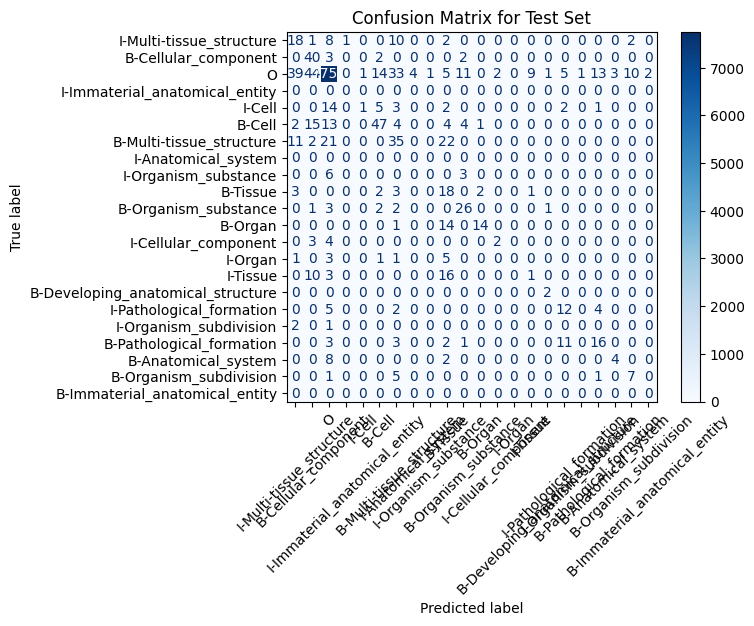

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Funzione per calcolare le predizioni e le etichette vere
def get_predictions_and_labels(trainer, dataset):
    # Ottieni predizioni dal modello
    predictions, labels, _ = trainer.predict(dataset)

    # Convertire le predizioni probabilistiche in etichette
    predictions = np.argmax(predictions, axis=2)

    # Filtra i token speciali (-100) dalle etichette
    true_labels = [
        [label for label in label_seq if label != -100]
        for label_seq in labels
    ]
    pred_labels = [
        [pred for pred, label in zip(pred_seq, label_seq) if label != -100]
        for pred_seq, label_seq in zip(predictions, labels)
    ]

    # Appiattire le liste per calcolare la matrice di confusione
    true_labels = [item for sublist in true_labels for item in sublist]
    pred_labels = [item for sublist in pred_labels for item in sublist]

    return true_labels, pred_labels

# Etichette vere e predette dal test set
true_labels, pred_labels = get_predictions_and_labels(trainer_fine_tuned, tokenized_datasets['test'])
# Calcolare la matrice di confusione
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=list(tag2id.values()))

# Mappare gli ID delle etichette ai nomi dei tag NER
labels = [id2tag[id_] for id_ in tag2id.values()]
# Visualizzare la matrice di confusione
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Test Set")
plt.show()


# Predictions
In this section, we use the fine-tuned BioBERT model to predict Named Entity Recognition (NER) tags for new sentences. The function tokenizes the input, processes it through the model, and maps the predicted labels back to the corresponding tokens. Sub-tokens are merged into complete words, ensuring the predictions align with the original text.

In the provided examples, the model assigns the label "O" to all tokens, indicating that it classifies them as non-entities. This behavior is consistent with the training dataset, where the "O" label (representing non-entities) is the most prevalent. While this result reflects the dataset's imbalance, it also suggests that the specific sentences used may not contain recognizable biomedical entities, as defined by the model’s training

In [64]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

# Specificare la directory dove sono salvati i file
model_directory = "/content/drive/MyDrive/Assignment3/fine_tuned_model"

# Caricare il modello fine-tunato e il tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_directory)
tokenizer = AutoTokenizer.from_pretrained(model_directory)

# Funzione di predizione
def predict_ner(sentence):
    # Tokenizzare la frase
    inputs = tokenizer.encode_plus(
        sentence,
        return_tensors='pt',             # Restituisce l'output come tensori PyTorch
        is_split_into_words=False,       # Input è una frase completa
        truncation=True,
        max_length=128                   # Lunghezza max usata durante l'addestramento
    )
    input_ids = inputs['input_ids']

    model.eval()  # Metti il modello in modalità valutazione per evitare modifiche ai pesi

    # Ottenere le predizioni
    with torch.no_grad():
        outputs = model(**inputs)  # Ottieni i logits
        predictions = torch.argmax(outputs.logits, dim=2)[0].numpy()  # Per ogni token seleziona la classe con la probabilità più alta

    # Convertire input_ids in token
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Ricostruire le parole dai sub-token e assegnare le etichette
    words = []
    labels = []
    for idx, (token, pred) in enumerate(zip(tokens, predictions)):
        if token in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
            continue
        if token.startswith('##'):
            words[-1] += token[2:]  # Combina sub-token
        else:
            words.append(token)
            labels.append(id2tag[pred])  # Mappa l'indice della classe con il tag

    # Stampare le parole e le relative etichette
    print("\nPredizione:")
    print("Parola\tEtichetta")
    for word, label in zip(words, labels):
        print(f"{word}\t{label}")


# Test della funzione di predizione
print("\nEsempio di predizione:")
test_sentence_1 = "Aortic aneurysm was detected in the chest"
test_sentence_2 = "The fracture in the femur requires surgery"
predict_ner(test_sentence_1)
predict_ner(test_sentence_2)



Esempio di predizione:

Predizione:
Parola	Etichetta
aortic	I-Pathological_formation
aneurysm	B-Pathological_formation
was	O
detected	B-Pathological_formation
in	B-Pathological_formation
the	B-Pathological_formation
chest	B-Organism_subdivision

Predizione:
Parola	Etichetta
the	O
fracture	O
in	B-Multi-tissue_structure
the	B-Multi-tissue_structure
femur	B-Multi-tissue_structure
requires	O
surgery	O


In [65]:

from transformers import AutoModelForTokenClassification, AutoTokenizer

# Percorso corretto
save_directory = '/content/drive/MyDrive/saved_model3'

# Carica il modello e il tokenizer
model = AutoModelForTokenClassification.from_pretrained(save_directory, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(save_directory, local_files_only=True)

print("Modello e tokenizer caricati con successo!")



Modello e tokenizer caricati con successo!
